# 03 - Modeling

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import sklearn as skl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling as pp
import time

In [3]:
import sys
sys.path.append('../')

import src

In [4]:
plt.style.use('fivethirtyeight')
pd.set_option('precision', 4)

## Prepare data

In [5]:
df = pd.read_pickle('../data/training.pickle')

In [6]:
df.head(1)

,type,date,operation,lat,long,sex,age,ethnicity_self,ethnicity_officer,legislation,search_target,outcome,found_target,stripped,station,offense,success
observation_id,,,,,,,,,,,,,,,,,
d62c9e35-6293-45fc-aab6-706bdac1601e,Person search,2017-12-01 00:00:00+00:00,False,50.9234,-0.4611,Male,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Offender given drugs possession warning,False,False,sussex,True,False


#### Drop metropolitan station from dataset

In [8]:
df = df[df.station!='metropolitan']
df.shape

(309317, 17)

#### Select relevant columns

Requests will have the following format:
```
["observation_id": <string>,
 "Type": <string>,
 "Date": <string>,
 "Part of a policing operation": <boolean>,
 "Latitude": <float>,
 "Longitude": <float>,
 "Gender": <string>,
 "Age range": <string>,
 "Officer-defined ethnicity": <string>,
 "Legislation": <string>,
 "Object of search": <string>,
 "station": <string>]
 '''


In [9]:
supplied_columns = ['type', 'date', 'operation', 'lat', 'long', 'sex', 'age', 'ethnicity_officer', 'legislation', 'search_target', 'station']

In [10]:
X = df[supplied_columns]
y = df.success.values

### Processed Data Profile

In [112]:
profile = pp.ProfileReport(df[supplied_columns+['success']], title='Training Data Profiling Report', explorative=False, minimal=False, pool_size=0, progress_bar=True)
profile.to_file('../reports/profiling/processed_profile.html')

Summarize dataset:   0%|          | 0/26 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Pipeline

In [11]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, KBinsDiscretizer, StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from category_encoders.target_encoder import TargetEncoder

import datetime as dt

### Preprocessing
#### Categorical Features

##### Assume searches with missing operation field did not happen as part of policing operation.

In [12]:
# df.operation = df.operation.fillna(False)
operation_imputer = SimpleImputer(strategy='constant', fill_value=False)#, missing_values=None)

##### Replace missing legislations with 'unknown', then one-hot-encode column.

In [13]:
# df.legislation = df.legislation.astype('str').fillna('unknown').astype('category')
legislation_imputer = SimpleImputer(strategy='constant', fill_value='unknown')
legislation_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
legislation_preprocessor = Pipeline(steps=[('legislation_imputer', legislation_imputer),
                                           ('legislation_encoder', legislation_encoder)])

##### One-hot-encode categorical features

In [14]:
# categoricals = X.select_dtypes(['category']).columns.tolist()
# categoricals.remove('legislation') # feature is already dealt with
# categoricals.remove('ethnicity_officer') # will not use this feature to avoid explicit discrimination

categoricals = ['type', 'sex', 'age', 'search_target', 'station']
oh_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

##### Combine categorical preprocessing steps

In [15]:
cat_preprocessor = ColumnTransformer(transformers=[('operation', operation_imputer, ['operation']),
                                                   ('legislation', legislation_preprocessor, ['legislation']),
                                                   ('cat_encoder', oh_encoder, categoricals)],
                                     remainder='drop')

#### Coordinate Features

##### Fill missing coordinate data with station means

In [16]:
#coordinate_dict = X.groupby('station')[['lat', 'long']].mean().fillna(X.mean()).to_dict()
coordinate_dict = \
{'lat': {'avon-and-somerset': 51.33301534853675,
  'bedfordshire': 51.99520005035238,
  'btp': 52.04498213727202,
  'cambridgeshire': 52.401295645642094,
  'cheshire': 53.27243561712015,
  'city-of-london': 51.515283227020134,
  'cleveland': 54.581267715107955,
  'cumbria': 54.53797709350655,
  'derbyshire': 53.01032026513161,
  'devon-and-cornwall': 50.53555175443321,
  'dorset': 50.71701186632197,
  'durham': 54.68330272246215,
  'dyfed-powys': 52.06194421428571,
  'essex': 51.72007429847026,
  'gloucestershire': 51.84977152248181,
  'greater-manchester': 53.47859898644197,
  'gwent': 51.60761234256556,
  'hampshire': 50.93652569163378,
  'hertfordshire': 51.76037049985289,
  'humberside': 53.48481868431375,
  'kent': 51.374468082246494,
  'lancashire': 53.78500562755108,
  'leicestershire': 52.65751631679406,
  'lincolnshire': 53.10683554523824,
  'merseyside': 53.436241618732225,
  'metropolitan': 52.515362957924715,
  'norfolk': 52.64006103976567,
  'north-wales': 53.17569351116731,
  'north-yorkshire': 54.041700087409595,
  'northamptonshire': 52.29232862938288,
  'northumbria': 54.98786282962144,
  'nottinghamshire': 52.98302869082842,
  'south-yorkshire': 52.515362957924715,
  'staffordshire': 52.87808759739836,
  'suffolk': 52.139193867362344,
  'surrey': 51.32796300224013,
  'sussex': 50.90980622282589,
  'thames-valley': 51.69650944703028,
  'warwickshire': 52.36734886374945,
  'west-mercia': 52.413887931124385,
  'west-yorkshire': 53.77299550808837,
  'wiltshire': 51.37899916477772},
 'long': {'avon-and-somerset': -2.6959433559473505,
  'bedfordshire': -0.4249400266868079,
  'btp': -0.7715286391456624,
  'cambridgeshire': -0.04725813646789005,
  'cheshire': -2.6387643686903965,
  'city-of-london': -0.0896220290722526,
  'cleveland': -1.2457966712230222,
  'cumbria': -3.136673164935065,
  'derbyshire': -1.4773875202376467,
  'devon-and-cornwall': -4.066873729177866,
  'dorset': -2.0917077684638166,
  'durham': -1.594638016918649,
  'dyfed-powys': -4.084971542857141,
  'essex': 0.538986324416861,
  'gloucestershire': -2.188883543046356,
  'greater-manchester': -2.248505129745514,
  'gwent': -3.0290781326530665,
  'hampshire': -1.1898053439685032,
  'hertfordshire': -0.2575871883632099,
  'humberside': -0.4107479908496726,
  'kent': 0.5604151309456336,
  'lancashire': -2.7154059084062276,
  'leicestershire': -1.1627258218159886,
  'lincolnshire': -0.35191183908730256,
  'merseyside': -2.9378837346396676,
  'metropolitan': -1.3420896304429029,
  'norfolk': 1.1136251113436533,
  'north-wales': -3.5303938708385822,
  'north-yorkshire': -1.1725005511775388,
  'northamptonshire': -0.8297320040567943,
  'northumbria': -1.5853070855440516,
  'nottinghamshire': -1.1530782153432024,
  'south-yorkshire': -1.3420896304429029,
  'staffordshire': -2.0221622171637286,
  'suffolk': 1.0365897135618494,
  'surrey': -0.4413027473143175,
  'sussex': -0.16365491495299755,
  'thames-valley': -0.9660928864365886,
  'warwickshire': -1.4958054560654521,
  'west-mercia': -2.3846032813072715,
  'west-yorkshire': -1.6477957410954118,
  'wiltshire': -1.9166443269398472}}

In [17]:
coordinate_imputer = FunctionTransformer(src.modeling.fill_coordinates_with_station_means)
coordinate_discretizer = KBinsDiscretizer(n_bins=50, encode='ordinal')
coordinate_categorizer = FunctionTransformer(src.modeling.grid_to_category)
coordinate_encoder = TargetEncoder(cols=None, handle_missing='value', handle_unknown='value')

In [18]:
coordinate_preprocessor = Pipeline(steps=[('fill_means', coordinate_imputer),
                                          ('discretize', coordinate_discretizer),
                                          ('categorizer', coordinate_categorizer),
                                          ('encode', coordinate_encoder),
                                         ])

#### Datetime features

In [19]:
date_extractor = FunctionTransformer(src.modeling.extract_datetime_features)
date_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
date_scaler = StandardScaler()

In [20]:
date_transformer = ColumnTransformer(transformers=[('oh_encoder', date_encoder, ['hour', 'weekday']),
                                                   ('scaler', date_scaler, ['daycount', 'sqrt_daycount']),
                                                  ])

In [21]:
date_preprocessor = Pipeline(steps=[('extract', date_extractor),
                                    ('transform', date_transformer)])

#### Combine all preprocessing steps

In [22]:
feature_preprocessor = FeatureUnion(transformer_list=[('categoricals', cat_preprocessor),
                                                      ('location', coordinate_preprocessor),
                                                      ('date', date_preprocessor)])

### Model Selection

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_score, roc_auc_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

#### Train-Validation Split

In [24]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=0, stratify=X[['station']], shuffle=True)

#### Plain-Vanilla Models

In [25]:
# tree-based models
dtc = ('Decision Tree', DecisionTreeClassifier())
rfc = ('Random Forest', RandomForestClassifier())

# nonlinear regression models
lrc = ('Logistic Regression', LogisticRegression())
sgd = ('Stochastic Gradient', SGDClassifier(loss='log'))

# other classifiers
svc = SVC() #too slow
gbc = GradientBoostingClassifier() #too slow

# gradient boosting methods
abc = ('Ada Boost', AdaBoostClassifier()) #slow but okay
xgb = ('XG Boost', XGBClassifier()) #okay
lgbm = ('Light GBM', LGBMClassifier()) #fast
cbc = ('Cat Boost', CatBoostClassifier(iterations=100)) #keeps crashing

In [26]:
classifiers = [dtc, rfc, lrc, sgd, abc, lgbm]

In [142]:
%%time
df_plain_models = pd.DataFrame(index=['Benchmark']+[name for (name, clf) in classifiers],
                               columns=pd.MultiIndex.from_product([['train', 'val'], []]))

# evaluate benchmark
df_plain_models.at['Benchmark', ('all', 'time')] = 0
df_plain_models.at['Benchmark', ('all', 'precision')] = precision_score(y, np.ones(y.shape))
df_plain_models.at['Benchmark', ('all', 'auroc')] = roc_auc_score(y, np.ones(y.shape))
df_plain_models.at['Benchmark', ('all', 'within_station')] = src.evaluate.within_station_discrepancy(np.ones(y.shape), y, X).max()
df_plain_models.at['Benchmark', ('all', 'within_station_std')] = src.evaluate.within_station_discrepancy(np.ones(y.shape), y, X).std()
df_plain_models.at['Benchmark', ('all', 'across_station')] = src.evaluate.across_station_discrepancy(np.ones(y.shape), y, X)
df_plain_models.at['Benchmark', ('all', 'across_group')] = src.evaluate.across_subgroup_discrepancy(np.ones(y.shape), y, X)

for name, clf in classifiers:
    # build pipeline
    pipeline = Pipeline(steps=[('preprocess', feature_preprocessor),
                               ('clf', clf)],
                        verbose=False)
    
    # train
    t = time.time()
    pipeline.fit(X_train, y_train)
    elapsed = time.time() - t
    df_plain_models.at[name, ('train', 'time')] = elapsed
    
    # predict
    authorised_train = src.evaluate.authorise_search(pipeline, X_train)
    authorised_val = src.evaluate.authorise_search(pipeline, X_val)
    pred_train = pipeline.predict(X_train)
    pred_val = pipeline.predict(X_val)
    
    # evaluate
    df_plain_models.at[name, ('train', 'precision')] = precision_score(y_train, authorised_train)
    df_plain_models.at[name, ('val', 'precision')] = precision_score(y_val, authorised_val)
    
    df_plain_models.at[name, ('train', 'auroc')] = roc_auc_score(y_train, authorised_train)
    df_plain_models.at[name, ('val', 'auroc')] = roc_auc_score(y_val, authorised_val)
    
    df_plain_models.at[name, ('train', 'within_station')] = src.evaluate.within_station_discrepancy(authorised_train, y_train, X_train).max()
    df_plain_models.at[name, ('val', 'within_station')] = src.evaluate.within_station_discrepancy(authorised_val, y_val, X_val).max()
    
    df_plain_models.at[name, ('train', 'within_station_std')] = src.evaluate.within_station_discrepancy(authorised_train, y_train, X_train).std()
    df_plain_models.at[name, ('val', 'within_station_std')] = src.evaluate.within_station_discrepancy(authorised_val, y_val, X_val).std()
    
    df_plain_models.at[name, ('train', 'across_station')] = src.evaluate.across_station_discrepancy(authorised_train, y_train, X_train)
    df_plain_models.at[name, ('val', 'across_station')] = src.evaluate.across_station_discrepancy(authorised_val, y_val, X_val)
    
    df_plain_models.at[name, ('train', 'across_group')] = src.evaluate.across_subgroup_discrepancy(authorised_train, y_train, X_train)
    df_plain_models.at[name, ('val', 'across_group')] = src.evaluate.across_subgroup_discrepancy(authorised_val, y_val, X_val)
    
    print('Trained {} in {}'.format(name, elapsed))
    
df_plain_models.to_pickle('../data/df_plain_models.pickle')

/home/rubelrennfix/.virtualenvs/capstone/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:222: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/home/rubelrennfix/.virtualenvs/capstone/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:222: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/home/rubelrennfix/.virtualenvs/capstone/lib/python3.6/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Trained Decision Tree in 23.23686671257019


/home/rubelrennfix/.virtualenvs/capstone/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:222: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/home/rubelrennfix/.virtualenvs/capstone/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:222: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/home/rubelrennfix/.virtualenvs/capstone/lib/python3.6/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Trained Random Forest in 94.64336061477661


/home/rubelrennfix/.virtualenvs/capstone/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:222: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/home/rubelrennfix/.virtualenvs/capstone/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:222: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/home/rubelrennfix/.virtualenvs/capstone/lib/python3.6/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/rubelrennfix/.virtualenvs/capstone/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTA

Trained Logistic Regression in 18.465213537216187


/home/rubelrennfix/.virtualenvs/capstone/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:222: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/home/rubelrennfix/.virtualenvs/capstone/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:222: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/home/rubelrennfix/.virtualenvs/capstone/lib/python3.6/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Trained Stochastic Gradient in 8.115864515304565


/home/rubelrennfix/.virtualenvs/capstone/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:222: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/home/rubelrennfix/.virtualenvs/capstone/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:222: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/home/rubelrennfix/.virtualenvs/capstone/lib/python3.6/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Trained Ada Boost in 105.11181211471558


/home/rubelrennfix/.virtualenvs/capstone/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:222: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/home/rubelrennfix/.virtualenvs/capstone/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:222: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/home/rubelrennfix/.virtualenvs/capstone/lib/python3.6/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Trained Light GBM in 8.779697179794312
CPU times: user 7min 21s, sys: 1min 22s, total: 8min 44s
Wall time: 8min 27s


#### Client fairness requirements:
This is a very interesting question. We are not data scientists here at the IT department, so please tell us in your report if our expectation is unreasonable. We would hope that (A) there would not be a discrepancy of more than 5 percentage points between population sub-groups, which would be defined as (B) a (station, ethnicity, gender) tuple, and that the discrepancy between stations (average per station) would not be larger than 10 percentage points.  We have no way to tell whether our expectations are realistic, of course, but trust that you can guide us in this process. Please note that we are only concerned about age when deciding about clothes removal. For now we are not interested in ages when deciding whether or not to conduct a search.


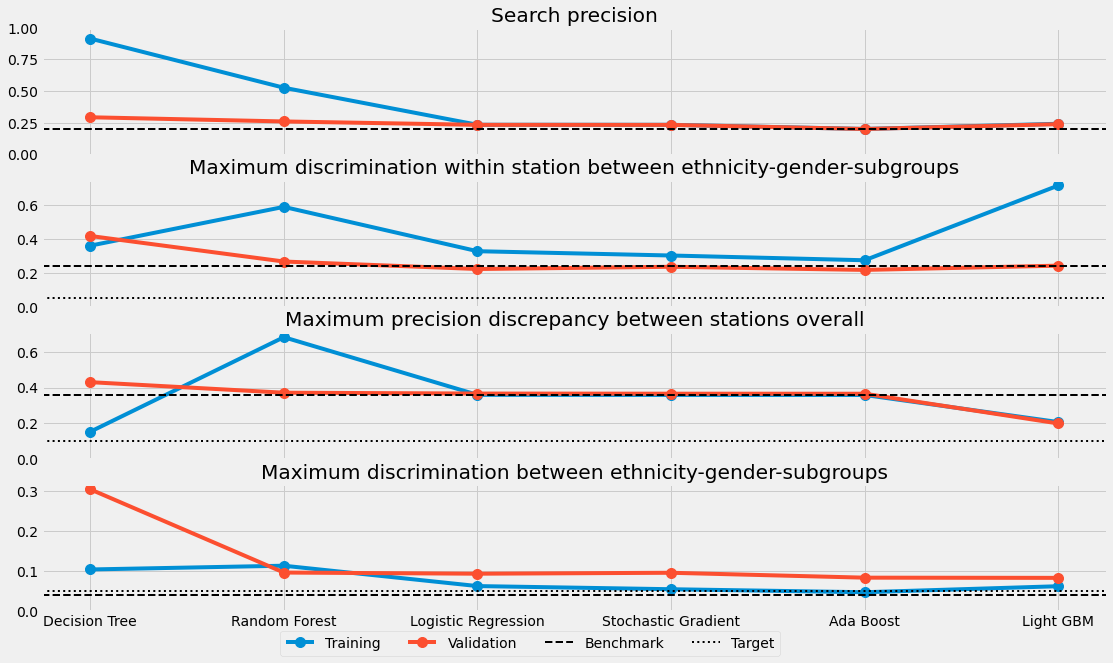

In [144]:
src.plots.make_evaluation_plot()

#### Cross-validation of hyperparameters

In [27]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

In [28]:
# set model pipeline
pipeline = Pipeline(steps=[('preprocess', feature_preprocessor),
                           ('clf', sgd[1])],
                        verbose=False)

# set CV parameters
grid = {'clf__penalty': ['elasticnet'],
        'clf__alpha': np.geomspace(1e-6, 1e-2, 15),
        'clf__l1_ratio': [0]+np.geomspace(1e-5, 1e0, 15).tolist(),
        'clf__random_state': [0],
       }
split = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
cv = RandomizedSearchCV(pipeline, param_distributions=grid, scoring=precision_score, n_iter=30, n_jobs=3, cv=split, verbose=1, random_state=0)

In [29]:
%%time
# fit
cv.fit(X, y)

# store
pipeline_ = cv.best_estimator_

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/rubelrennfix/.virtualenvs/capstone/lib/python3.6/site-packages/sklearn/model_selection/_search.py:921: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
  category=UserWarning
/home/rubelrennfix/.virtualenvs/capstone/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:222: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/home/rubelrennfix/.virtualenvs/capstone/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:222: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/home/rubelrennfix/.virtualenvs/capstone/lib/python3.6/site-packages/category_encoders/utils.py:21: FutureWarning: is_cat

CPU times: user 45.6 s, sys: 6.5 s, total: 52.1 s
Wall time: 21min 10s


In [104]:
skl.set_config(display='diagram') #'text'
pipeline_

Pipeline(steps=[('preprocess',
                 FeatureUnion(transformer_list=[('categoricals',
                                                 ColumnTransformer(transformers=[('operation',
                                                                                  SimpleImputer(fill_value=False,
                                                                                                strategy='constant'),
                                                                                  ['operation']),
                                                                                 ('legislation',
                                                                                  Pipeline(steps=[('legislation_imputer',
                                                                                                   SimpleImputer(fill_value='unknown',
                                                                                                                 strategy='constant')),
                                                                                                  ('legislation_encoder',
                                                                                                   OneHotEncoder(handle_unknow...
                                                                  FunctionTransformer(func=<function extract_datetime_features at 0x7f9d27ee5048>)),
                                                                 ('transform',
                                                                  ColumnTransformer(transformers=[('oh_encoder',
                                                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                                                 sparse=False),
                                                                                                   ['hour',
                                                                                                    'weekday']),
                                                                                                  ('scaler',
                                                                                                   StandardScaler(),
                                                                                                   ['daycount',
                                                                                                    'sqrt_daycount'])]))]))])),
                ('clf',
                 SGDClassifier(alpha=5.1794746792312125e-05,
                               l1_ratio=0.19306977288832497, loss='log',
                               penalty='elasticnet', random_state=0))])

#### Analyse Results

##### Success metrics

In [32]:
# set up
df_results = pd.DataFrame(index=['Search precision',
                                 'Maximum discrimination within station between ethnicity-gender-subgroup',
                                 'Maximum precision discrepancy between stations overall',
                                 'Maximum discrimination between ethnicity-gender-subgroups'],
                          columns=['Model', 'Benchmark', 'Target'])

# pipeline
authorised = src.evaluate.authorise_search(pipeline_, X)
df_results.iat[0, 0] = precision_score(y, authorised)
df_results.iat[1, 0] = src.evaluate.within_station_discrepancy(authorised, y, X).max()
df_results.iat[2, 0] = src.evaluate.across_station_discrepancy(authorised, y, X)
df_results.iat[3, 0] = src.evaluate.across_subgroup_discrepancy(authorised, y, X)

# evaluate benchmark
df_results.iat[0, 1] = precision_score(y, np.ones(y.shape))
df_results.iat[1, 1] = src.evaluate.within_station_discrepancy(np.ones(y.shape), y, X).max()
df_results.iat[2, 1] = src.evaluate.across_station_discrepancy(np.ones(y.shape), y, X)
df_results.iat[3, 1] = src.evaluate.across_subgroup_discrepancy(np.ones(y.shape), y, X)

# targets
df_results.iat[0, 2] = '-'
df_results.iat[1, 2] = 0.05
df_results.iat[2, 2] = 0.1
df_results.iat[3, 2] = 0.05

df_results

,Model,Benchmark,Target
Search precision,0.2401,0.2014,-
Maximum discrimination within station between ethnicity-gender-subgroup,0.2681,0.24,0.05
Maximum precision discrepancy between stations overall,0.1974,0.3602,0.1
Maximum discrimination between ethnicity-gender-subgroups,0.05137,0.04013,0.05


##### Confusion Matrix

In [33]:
authorised = src.evaluate.authorise_search(pipeline_, X)
pd.DataFrame(confusion_matrix(y, authorised),
             index=pd.MultiIndex.from_product([['True outcome'], ['no succes', 'success']]),
             columns=pd.MultiIndex.from_product([['Predicted outcome'], ['no succes', 'success']]),
            )

Predicted outcome        
                               no succes success
True outcome no succes             63572  183459
             success                4335   57951

##### Fairness

In [36]:
src.evaluate.calculate_subgroup_precisions(authorised, y, X, grouping=['ethnicity', 'gender']).unstack()

gender,Female,Male
ethnicity,,
Asian,0.2323,0.2358
Black,0.2267,0.2375
Mixed,0.2039,0.2360
Other,0.2553,0.2422
White,0.2121,0.2447


In [87]:
src.evaluate.calculate_subgroup_precisions(np.ones(y.shape), y, X, grouping=['ethnicity', 'gender']).unstack()

gender,Female,Male
ethnicity,,
Asian,0.1936,0.2006
Black,0.1991,0.2076
Mixed,0.1864,0.2119
Other,0.2194,0.2126
White,0.1793,0.2031


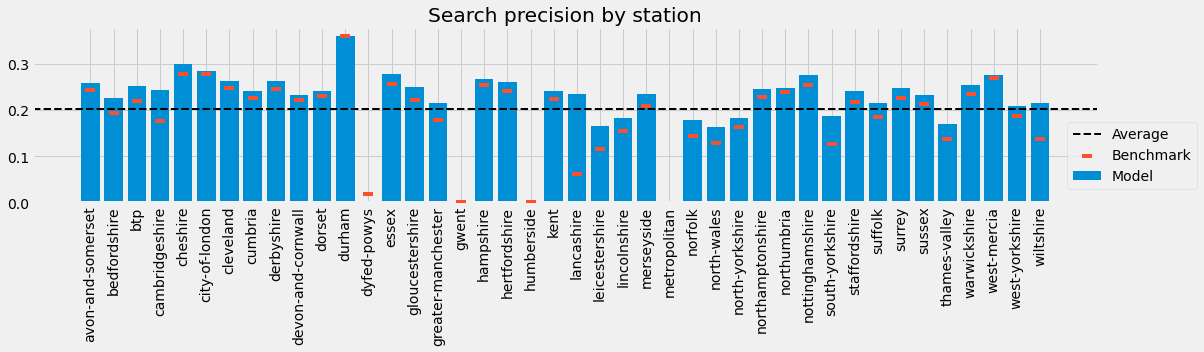

In [86]:
fig, ax = plt.subplots(1, 1, figsize=(17,3))

ax.set_title('Search precision by station')
ax.bar(x=np.arange(0, 42, 1), height=src.evaluate.calculate_subgroup_precisions(authorised, y, X, grouping=['station']), label='Model')
ax.scatter(x=np.arange(0, 42, 1), y=src.evaluate.calculate_subgroup_precisions(np.ones(y.shape), y, X, grouping=['station']), zorder=10, label='Benchmark', marker='_', s=100)
ax.axhline(precision_score(y, np.ones(y.shape)), linewidth=2, linestyle='--', c='k', label='Average')
ax.set_xticks(np.arange(0, 42, 1))
ax.set_xticklabels(df_station_precision.index, rotation=90)
ax.legend(bbox_to_anchor=(1.1, 0.5), ncol=1)

plt.show()

fig.savefig('../reports/figures/staions_precision.jpg', dpi=300, bbox_inches='tight')

### Serialise

In [30]:
import json
import pickle
import joblib

In [31]:
# serialise
with open('../deploy/columns.json', 'w') as fh:
    json.dump(X.columns.tolist(), fh)
    
with open('../deploy/dtypes.pickle', 'wb') as fh:
    pickle.dump(X.dtypes, fh)
    
joblib.dump(pipeline_, '../deploy/pipeline.pickle')

['../deploy/pipeline.pickle']